<a href="https://colab.research.google.com/github/patrick-seib/econ-489/blob/main/489_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import pandas as pd
from google.colab import drive
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base import  datetools

drive.mount('/content/drive/')
df = pd.read_csv('/content/drive/My Drive/489_Data/household_expenditure.csv', index_col=0)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


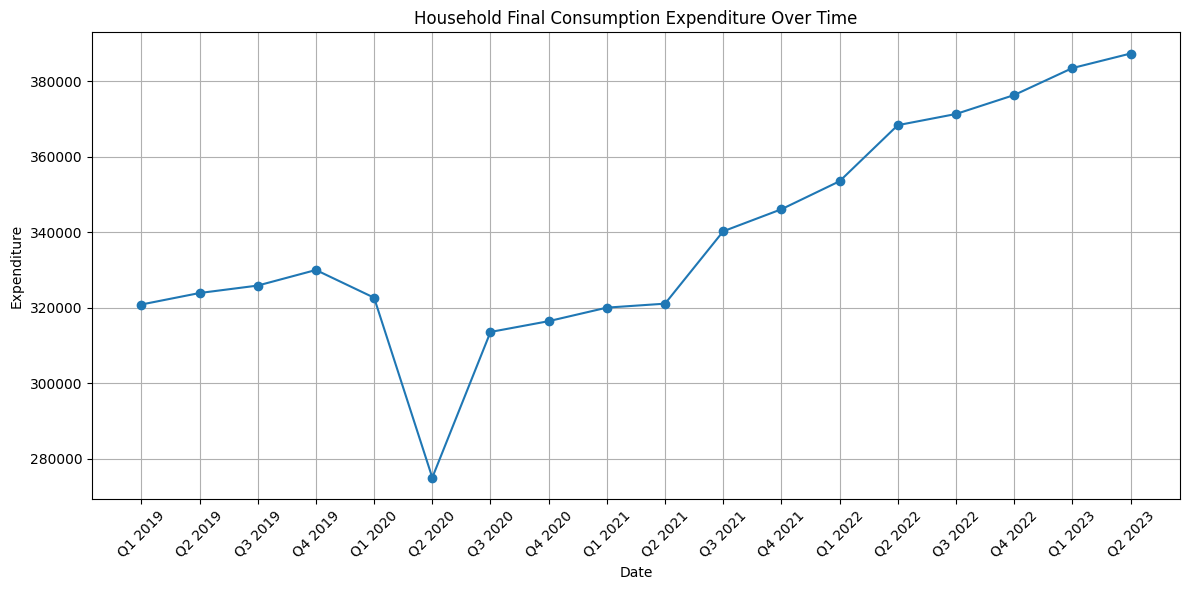

In [41]:
df['Household final consumption expenditure'] = pd.to_numeric(
    df['Household final consumption expenditure'].str.replace(',', ''),
    errors='coerce'
)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Household final consumption expenditure'], marker='o', linestyle='-')
plt.title('Household Final Consumption Expenditure Over Time')
plt.xlabel('Date')
plt.ylabel('Expenditure')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


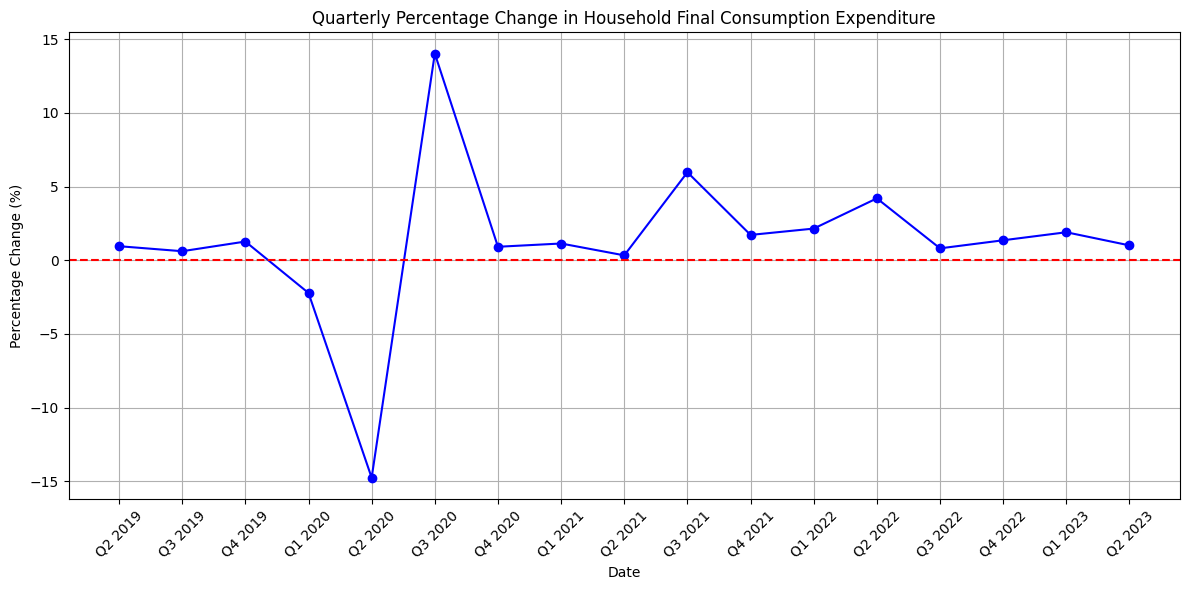

In [42]:
# Calculate the percentage change for each quarter
df['Pct_Change'] = df['Household final consumption expenditure'].pct_change() * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Pct_Change'], marker='o', linestyle='-', color='b')
plt.title('Quarterly Percentage Change in Household Final Consumption Expenditure')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


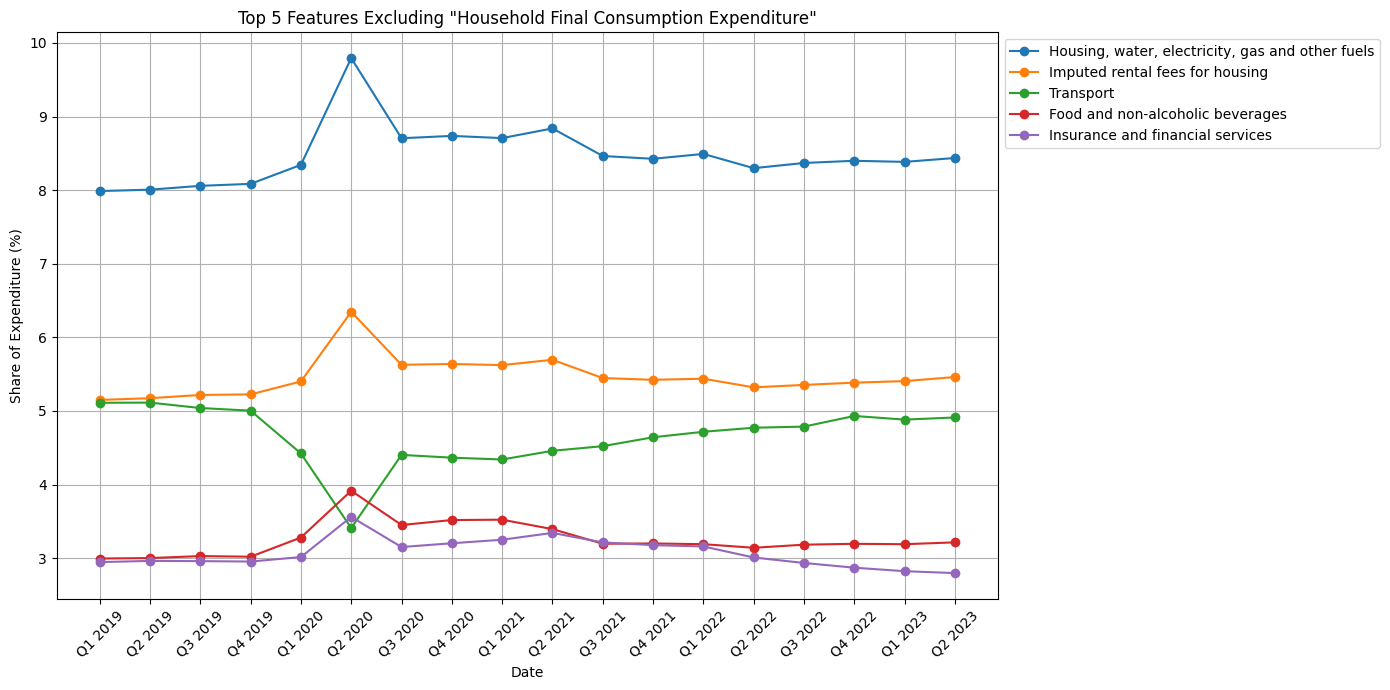

(None,
 Index(['Housing, water, electricity, gas and other fuels',
        'Imputed rental fees for housing', 'Transport',
        'Food and non-alcoholic beverages', 'Insurance and financial services'],
       dtype='object'))

In [43]:
import matplotlib.pyplot as plt

# Convert the data to numeric, handling commas
household_data_numeric = df.applymap(lambda x: pd.to_numeric(str(x).replace(',', ''), errors='coerce'))

# Calculate the total expenditure for each time period
total_expenditure = household_data_numeric.sum(axis=1)

# Calculate the share of each feature in household expenditure
share_of_expenditure = (household_data_numeric.div(total_expenditure, axis=0)) * 100

# Calculate the average share of each feature and identify the top 5 features
avg_share = share_of_expenditure.mean().sort_values(ascending=False)
top_5_features = avg_share.head(5).index

# Exclude "Household final consumption expenditure" and find the next top 5 features
top_5_features_excl = avg_share.drop('Household final consumption expenditure').head(5).index

# Plotting
plt.figure(figsize=(14, 7))
for feature in top_5_features_excl:
    plt.plot(share_of_expenditure.index, share_of_expenditure[feature], marker='o', label=feature)

plt.title('Top 5 Features Excluding "Household Final Consumption Expenditure" as a share of the total')
plt.xlabel('Date')
plt.ylabel('Share of Expenditure (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show(), top_5_features_excl


Looking at the top 10 features with the highest rates of change over time


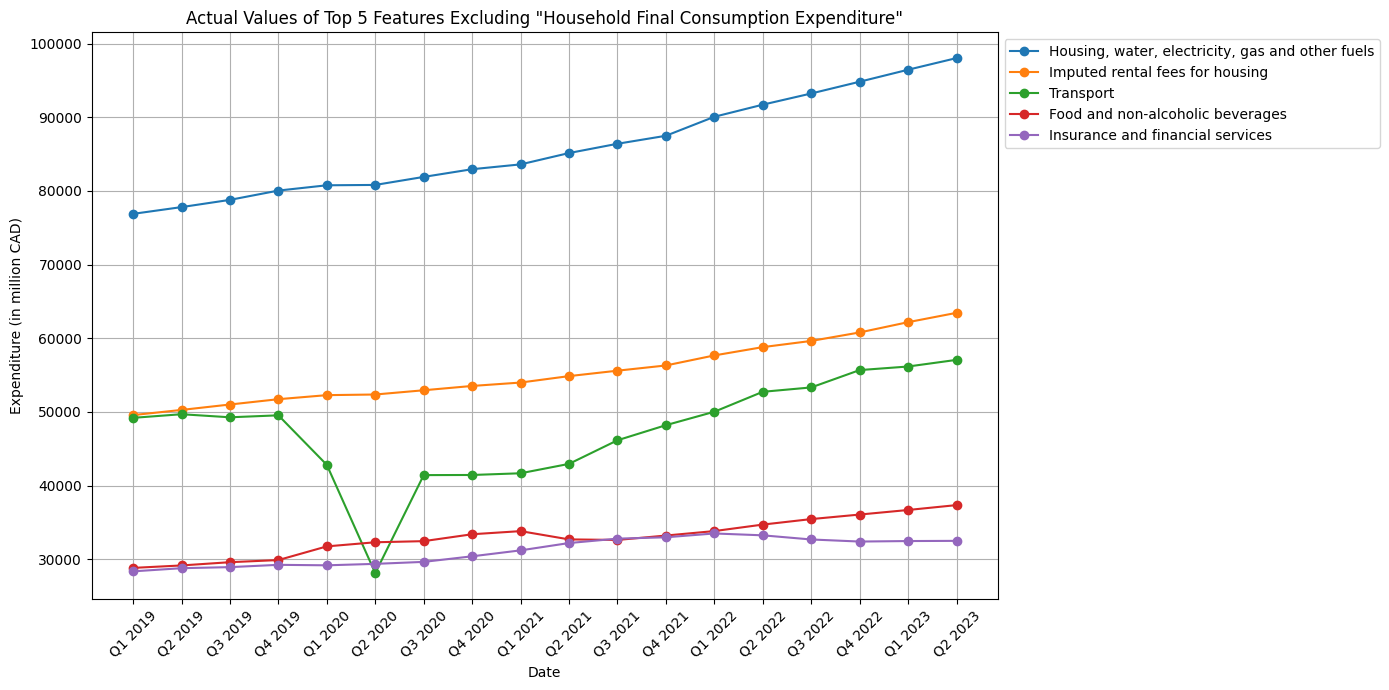

In [44]:
# Plotting actual values of the top 5 features (excluding Household final consumption expenditure)
plt.figure(figsize=(14, 7))
for feature in top_5_features_excl:
    plt.plot(household_data_numeric.index, household_data_numeric[feature], marker='o', label=feature)

plt.title('Actual Values of Top 5 Features Excluding "Household Final Consumption Expenditure"')
plt.xlabel('Date')
plt.ylabel('Expenditure (in million CAD)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

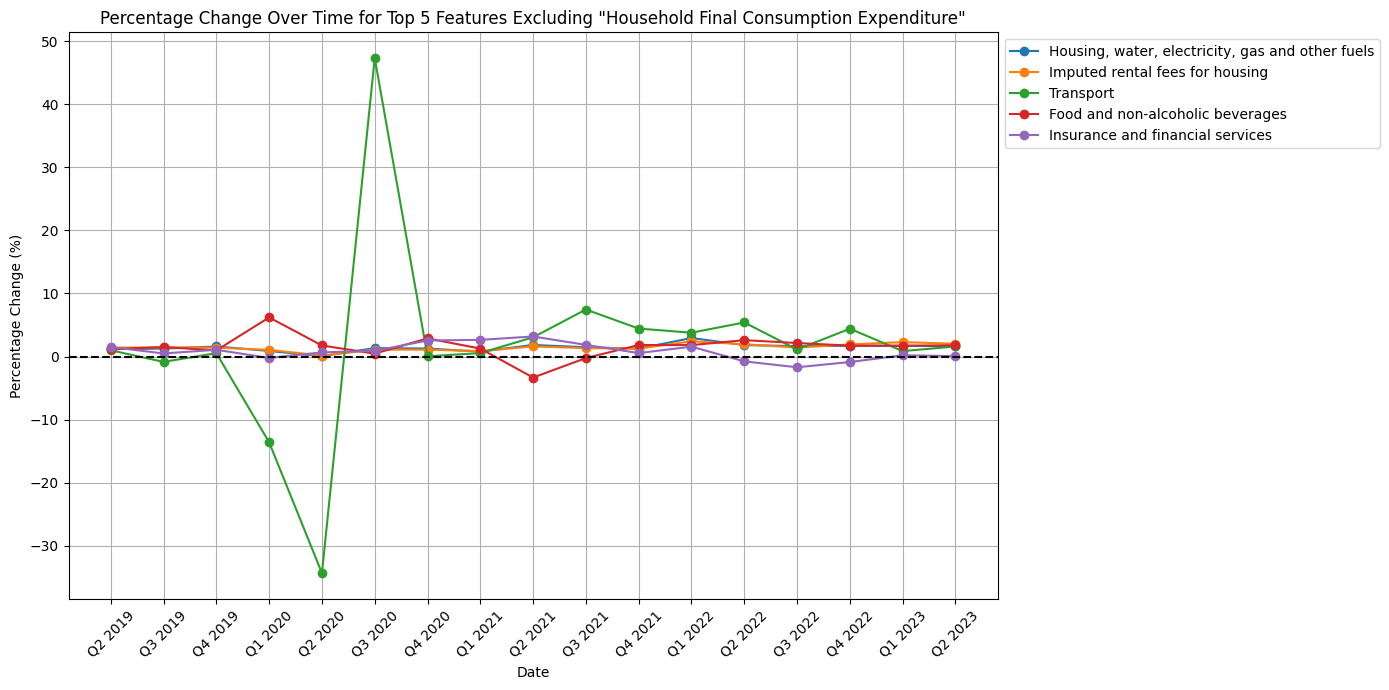

In [45]:
# Calculate the percentage change for each quarter for the top 5 features
pct_change_top_5 = household_data_numeric[top_5_features_excl].pct_change() * 100

# Plotting
plt.figure(figsize=(14, 7))
for feature in top_5_features_excl:
    plt.plot(pct_change_top_5.index, pct_change_top_5[feature], marker='o', label=feature)

plt.title('Percentage Change Over Time for Top 5 Features Excluding "Household Final Consumption Expenditure"')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

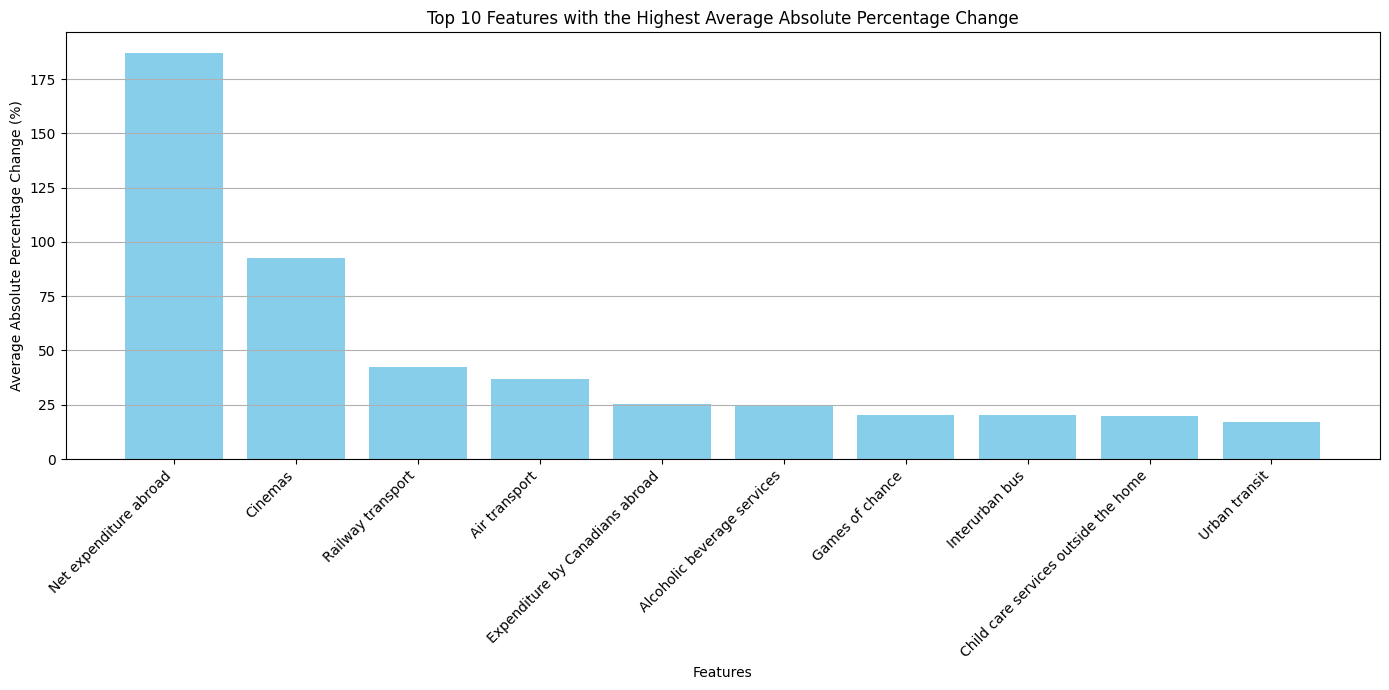

(None,
 Net expenditure abroad                  187.214109
 Cinemas                                  92.743919
 Railway transport                        42.524088
 Air transport                            36.766387
 Expenditure by Canadians abroad          25.511797
 Alcoholic beverage services              25.100339
 Games of chance                          20.333763
 Interurban bus                           20.254258
 Child care services outside the home     19.746927
 Urban transit                            17.252748
 dtype: float64)

In [ ]:
# Replace commas and convert the data to numeric
numeric_data = df.applymap(lambda x: pd.to_numeric(str(x).replace(',', ''), errors='coerce'))

# Calculate the percentage change for all columns
pct_change_data = numeric_data.pct_change() * 100

# Calculate the average absolute percentage change for each feature
avg_abs_pct_change = pct_change_data.abs().mean().sort_values(ascending=False)

# Get the top 10 features (excluding 'Pct_Change') with the highest average absolute percentage change
top_10_change_excl_pct = avg_abs_pct_change.drop('Pct_Change').head(10)

# Plotting
plt.figure(figsize=(14, 7))
plt.bar(top_10_change_excl_pct.index, top_10_change_excl_pct.values, color='skyblue')
plt.title('Top 10 Features with the Highest Average Absolute Percentage Change')
plt.xlabel('Features')
plt.ylabel('Average Absolute Percentage Change (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()

# Show the plot
plt.show(), top_10_change_excl_pct


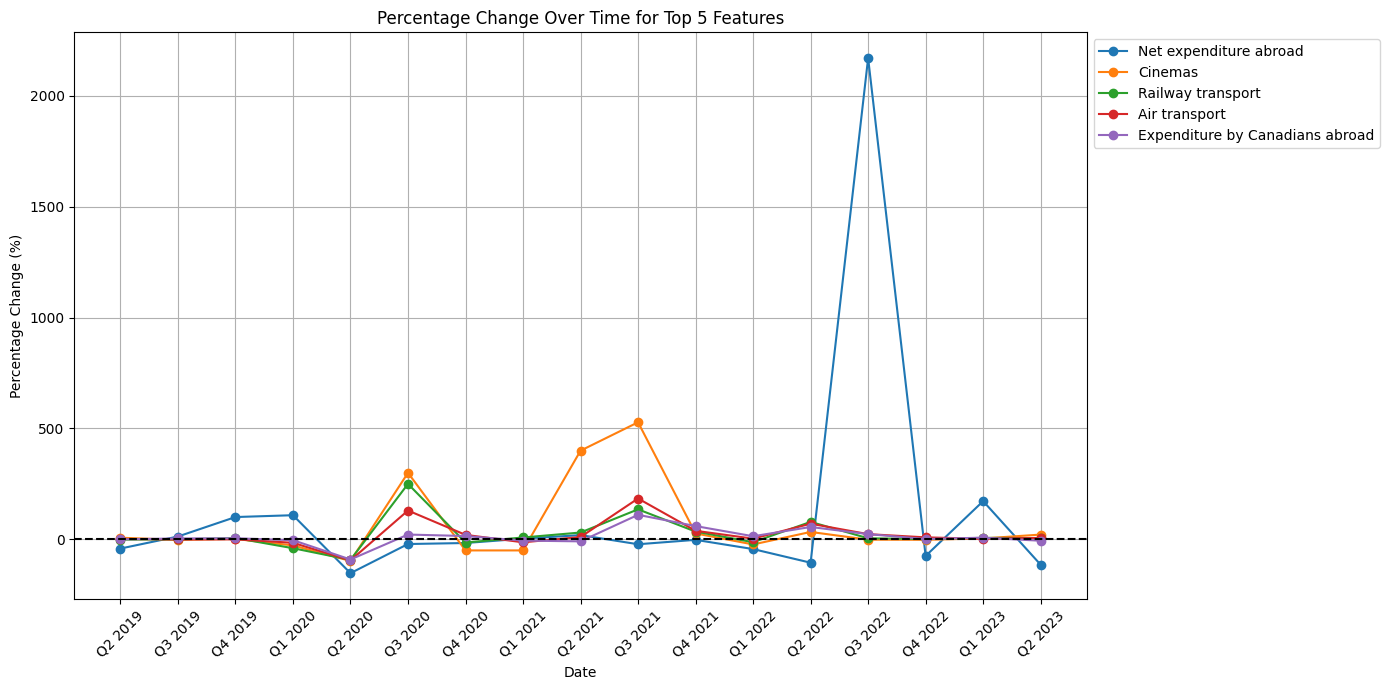

In [ ]:
avg_pct_change_top_10 = pct_change_data[top_10_change_excl_pct.index].mean()

# Extracting the top 5 features
top_5_features = avg_pct_change_top_10.head(5).index

# Plotting
plt.figure(figsize=(14, 7))
for feature in top_5_features:
    plt.plot(pct_change_data.index, pct_change_data[feature], marker='o', label=feature)

plt.title('Percentage Change Over Time for Top 5 Features')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


Moving on to net government expenditure

In [ ]:
# Load the cleaned data
cleaned_data = pd.read_csv('/content/drive/My Drive/489_Data/provincal_gov_transposed_cleaned_no_dots.csv', index_col=0)

# Display basic information and first few rows of the cleaned data without dot columns
cleaned_data.head()


,General governments revenue,Taxes on incomes,From households,Income taxes,Wealth transfer taxes,"From corporations and government business enterprises, liabilities",From non-residents (withholding taxes),Contributions to social insurance plans,Of which: employer and employee contributions to employment insurance,Taxes on production and imports,...,To non-residents,Interest on debt,General governments surplus or deficit,Plus: consumption of fixed capital,Less: non-financial capital acquisition,Fixed capital,New capital,Existing capital,Inventories,Equals: net lending or net borrowing
Date,,,,,,,,,,,,,,,,,,,,,
Q1 2019,"505,224","144,692","110,468","110,148",320,"34,224",..,"13,108",..,"140,036",...,0,"39,420","-6,180","36,660","39,236","38,844","38,844",0,392,"-8,756"
Q2 2019,"502,908","145,960","111,544","111,200",344,"34,416",..,"13,340",..,"140,796",...,0,"40,248","1,192","36,904","39,696","39,680","39,680",0,16,"-1,600"
Q3 2019,"495,348","146,992","112,328","111,968",360,"34,664",..,"13,460",..,"140,100",...,0,"40,212","-19,224","37,172","40,836","40,708","40,708",0,128,"-22,888"
Q4 2019,"501,868","148,180","113,216","112,864",352,"34,964",..,"13,200",..,"138,404",...,0,"40,400","-20,604","37,536","40,940","40,820","40,820",0,120,"-24,008"
Q1 2020,"499,488","150,108","112,812","112,504",308,"37,296",..,"12,708",..,"135,152",...,0,"39,960","-26,776","38,072","42,612","42,340","42,340",0,272,"-31,316"


In [47]:
# Convert the "Equals: net lending or net borrowing" to numeric, handling commas
cleaned_data['Equals: net lending or net borrowing'] = pd.to_numeric(
    cleaned_data['Equals: net lending or net borrowing'].replace(',', ''),
    errors='coerce'
)

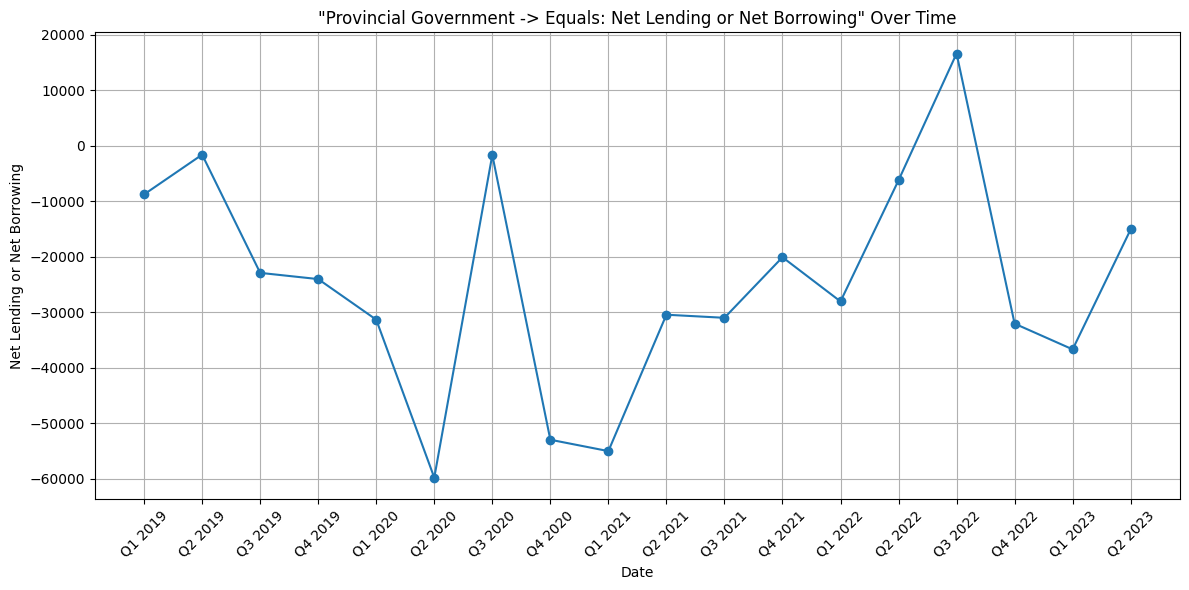

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(cleaned_data.index, cleaned_data['Equals: net lending or net borrowing'], marker='o', linestyle='-')
plt.title('"Provincial Government -> Equals: Net Lending or Net Borrowing" Over Time')
plt.xlabel('Date')
plt.ylabel('Net Lending or Net Borrowing')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
def clean_and_transpose(data_path, header_row_idx, data_start_row_idx, missing_val_indicator='.'):
    """
    Cleans and transposes a dataset of a similar structure to the provided examples.

    Parameters:
    - data_path (str): Path to the dataset.
    - header_row_idx (int): Index of the row which should be used as the header.
    - data_start_row_idx (int): Index of the first row of actual data.
    - missing_val_indicator (str): Symbol or value indicating missing or unavailable data, default is '.'.

    Returns:
    - pd.DataFrame: A cleaned and transposed DataFrame.
    """
    # Load and adjust the data
    data = pd.read_csv(data_path, skiprows=header_row_idx)
    adjusted_data = data.iloc[data_start_row_idx - header_row_idx:].copy()
    adjusted_data.columns = data.iloc[header_row_idx - header_row_idx]
    adjusted_data = adjusted_data.reset_index(drop=True).drop([0])

    # Transpose the data
    transposed_data = adjusted_data.set_index('Estimates').transpose()

    # Handle missing values
    transposed_data_clean = transposed_data.replace(missing_val_indicator, None)
    transposed_data_clean = transposed_data_clean.dropna(axis=1, how='all')

    return transposed_data_clean

# Test the function with the newly provided data
gov_df = pd.read_csv('/content/drive/My Drive/489_Data/federal_gov_expenditure_revenue.csv', index_col=0)


In [ ]:
gov_df['Equals: net lending or net borrowing'] = pd.to_numeric(
    gov_df['Equals: net lending or net borrowing'].str.replace(',', ''),
    errors='coerce'
)

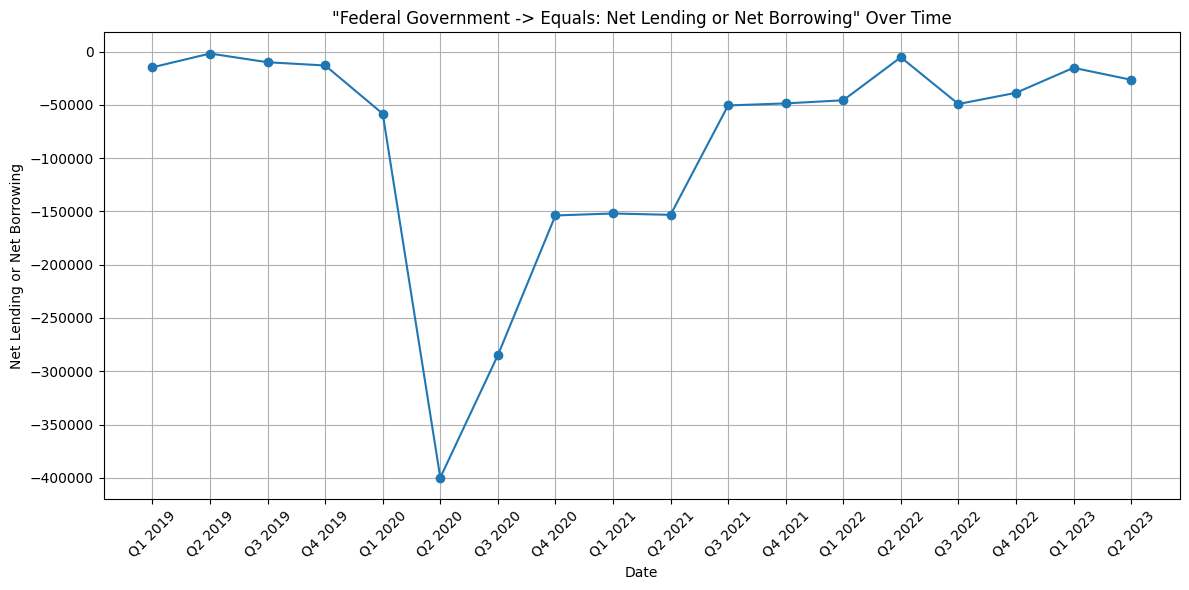

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(gov_df.index, gov_df['Equals: net lending or net borrowing'], marker='o', linestyle='-')
plt.title('"Federal Government -> Equals: Net Lending or Net Borrowing" Over Time')
plt.xlabel('Date')
plt.ylabel('Net Lending or Net Borrowing')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()